# Upload Dataset
This notebook extracts from the Colin Kaepernick Nike #JustDoIt Dataset information about the tweets and users who made them. The ultimate goal is to see if there are any insights that can be generated from the tweets to inform Nike's brand strategy in the United States.

In [7]:
# column names
value_col = "state_political_values"

In [8]:
import pandas as pd
import numpy as np
import re
import demoji
import upsetplot
import matplotlib.pyplot as plt
%matplotlib inline

## Read #JustDoIt! Tweets Dataset
The [JustDoIt tweets](https://www.kaggle.com/eliasdabbas/5000-justdoit-tweets-dataset) are uncleaned and missing many values. They have heavy use of emojis and no consistent reference to users' state of residence. It is also worth noting that currently not all tweets are actually about Nike's endorsement of Colin Kaepernick, some are instead referencing other events such as Serena Williams competing in the U.S. Open. To reduce biases in our analysis, we will clean the tweets' text data of "#", "@" and camelcase phrases, convert emojis to words using demoji, and the users' home state and home state [electoral college result](https://en.wikipedia.org/wiki/2016_United_States_elections) in the 2016 election.

In [9]:
#read dataset
tweetsdf = pd.read_csv('./data/justdoit_tweets_2018_09_07_2.csv')
print("Number of tweets:", tweetsdf.shape[0], "\n")
tweetsdf.head()

Number of tweets: 5089 



,tweet_contributors,tweet_coordinates,tweet_created_at,tweet_display_text_range,tweet_entities,tweet_extended_entities,tweet_favorite_count,tweet_favorited,tweet_full_text,tweet_geo,...,user_profile_text_color,user_profile_use_background_image,user_protected,user_screen_name,user_statuses_count,user_time_zone,user_translator_type,user_url,user_utc_offset,user_verified
0,NaN,NaN,Fri Sep 07 16:25:06 +0000 2018,"[0, 75]","{'hashtags': [{'text': 'quote', 'indices': [47...","{'media': [{'id': 1038100853872197632, 'id_str...",0,False,Done is better than perfect. — Sheryl Sandberg...,NaN,...,333333,True,False,UltraYOUwoman,91870.0,NaN,none,https://t.co/jGlJswxjwS,NaN,False
1,NaN,NaN,Fri Sep 07 16:24:59 +0000 2018,"[0, 237]","{'hashtags': [{'text': 'hero', 'indices': [90,...",NaN,0,False,Shout out to the Great Fire Department and the...,NaN,...,333333,True,False,yungcutup,618822.0,NaN,none,http://t.co/lVm8vfDbfO,NaN,False
2,NaN,NaN,Fri Sep 07 16:24:50 +0000 2018,"[0, 176]","{'hashtags': [{'text': 'JustDoIt', 'indices': ...","{'media': [{'id': 1038100773396041728, 'id_str...",0,False,There are some AMAZINGLY hilarious Nike Ad mem...,NaN,...,050505,True,False,rachelbogle,48075.0,NaN,none,https://t.co/g9exqgZp9x,NaN,True
3,NaN,"{'type': 'Point', 'coordinates': [-86.45594032...",Fri Sep 07 16:24:44 +0000 2018,"[0, 88]","{'hashtags': [{'text': 'kapernickeffect', 'ind...",NaN,0,False,#kapernickeffect #swoosh #justdoit @ Lucas Bis...,"{'type': 'Point', 'coordinates': [35.85402047,...",...,333333,True,False,ErvGotti609,1983.0,NaN,none,NaN,NaN,False
4,NaN,NaN,Fri Sep 07 16:24:39 +0000 2018,"[0, 132]","{'hashtags': [{'text': 'shaquem', 'indices': [...","{'media': [{'id': 1038100736595255296, 'id_str...",0,False,"One Hand, One Dream: The Shaquem Griffin Story...",NaN,...,1A1E1A,True,False,NoLuckNeeded,24989.0,NaN,none,http://t.co/MMGF9RfLz0,NaN,False


In [10]:
tweetsdf.columns

Index(['tweet_contributors', 'tweet_coordinates', 'tweet_created_at',
       'tweet_display_text_range', 'tweet_entities', 'tweet_extended_entities',
       'tweet_favorite_count', 'tweet_favorited', 'tweet_full_text',
       'tweet_geo', 'tweet_id', 'tweet_id_str',
       'tweet_in_reply_to_screen_name', 'tweet_in_reply_to_status_id',
       'tweet_in_reply_to_status_id_str', 'tweet_in_reply_to_user_id',
       'tweet_in_reply_to_user_id_str', 'tweet_is_quote_status', 'tweet_lang',
       'tweet_metadata', 'tweet_place', 'tweet_possibly_sensitive',
       'tweet_quoted_status', 'tweet_quoted_status_id',
       'tweet_quoted_status_id_str', 'tweet_retweet_count', 'tweet_retweeted',
       'tweet_source', 'tweet_truncated', 'tweet_user',
       'user_contributors_enabled', 'user_created_at', 'user_default_profile',
       'user_default_profile_image', 'user_description', 'user_entities',
       'user_favourites_count', 'user_follow_request_sent',
       'user_followers_count', 'user_fol

## Examine Percent of Missing Values Across Dataset
Use Upsetplot to see how often different columns have missing values concurrently

Text(0.5, 1.0, '> 40.0% Missing Value Columns Upset Plot')

<Figure size 1296x864 with 0 Axes>

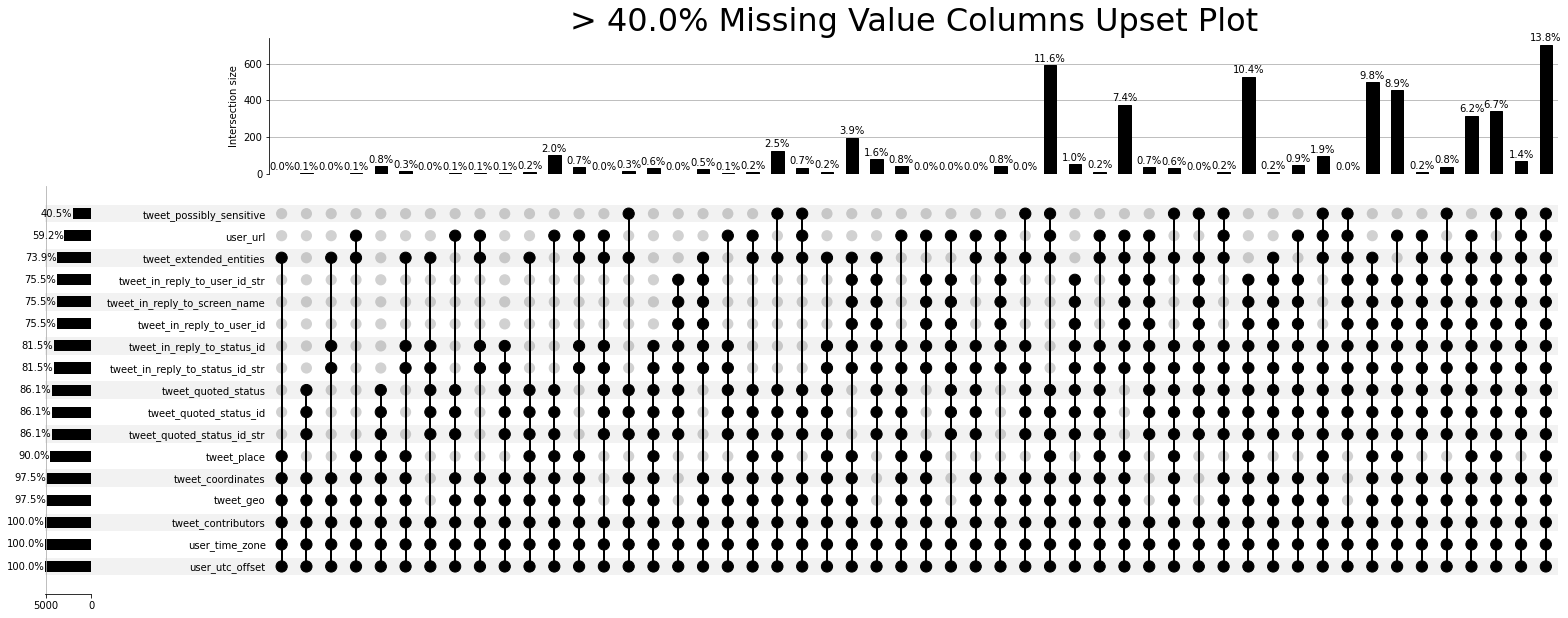

In [11]:
NA_tolerance = 0.4 #0.18

critical_columns = [c for c in list(tweetsdf.columns) if tweetsdf[c].isna().sum()/tweetsdf.shape[0] > NA_tolerance]

nadf = tweetsdf[critical_columns].isnull().groupby(critical_columns).size()

plt.figure(figsize=(18,12))

upsetplot.plot(nadf, show_percentages = True)
plt.title("> " + str(NA_tolerance*100) + "% Missing Value Columns Upset Plot", fontsize = 32)

## Remove All Unneccesary Features
Remove features with more than 40% missing values.

In [12]:
percent_missing = tweetsdf.isnull().sum() * 100 / len(tweetsdf)
missing_value_df = pd.DataFrame({'column_name': tweetsdf.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)

missing_value_df_40 = missing_value_df[missing_value_df['percent_missing'] < 40]['column_name'].to_list()

elements_to_remove = ['tweet_user', 'user_profile_banner_url', 'user_profile_link_color', 
                      'user_profile_background_image_url_https',
                      'tweet_retweeted', 'tweet_is_quote_status', 'user_default_profile', 
                      'user_default_profile_image', 'tweet_retweet_count', 'user_contributors_enabled',
                     'tweet_id_str', 'tweet_id', 'tweet_favorited', #'tweet_favorite_count',
                     'tweet_truncated', 'tweet_display_text_range', 'tweet_source', 'user_has_extended_profile',
                      'user_favourites_count', 'user_following', 'user_lang', 'tweet_lang',
                      'user_is_translator', 'user_is_translation_enabled', 'user_verified', 'tweet_metadata',
                     'tweet_entities', 'user_entities', 'user_listed_count', 'user_notifications',
                     'user_profile_background_tile', 'user_profile_image_url', 'user_id', 'user_geo_enabled',
                     'user_profile_background_image_url', 'user_follow_request_sent', 'user_translator_type',
                     'user_protected', 'user_statuses_count', 'user_id_str']


filtered_list = [element for element in missing_value_df_40 if element not in elements_to_remove]

tweetsdf2 = tweetsdf[filtered_list]
tweetsdf2 = tweetsdf2.dropna(subset=['user_location'])
tweetsdf2['user_location_State'] = '0'

print("Updated number of tweets:", tweetsdf2.shape[0], "\n")
tweetsdf2.head()

Updated number of tweets: 4024 



,user_created_at,tweet_full_text,tweet_favorite_count,tweet_created_at,user_name,user_profile_image_url_https,user_profile_sidebar_border_color,user_profile_sidebar_fill_color,user_profile_text_color,user_profile_use_background_image,user_screen_name,user_profile_background_color,user_friends_count,user_followers_count,user_description,user_location,user_location_State
0,Fri May 08 10:27:51 +0000 2015,Done is better than perfect. — Sheryl Sandberg...,0,Fri Sep 07 16:25:06 +0000 2018,Ultra YOU Woman,https://pbs.twimg.com/profile_images/597000926...,C0DEED,DDEEF6,333333,True,UltraYOUwoman,C0DEED,48721.0,57983.0,I share tips to achieve your health goals and ...,"California, USA",0
1,Fri Dec 26 09:30:23 +0000 2008,Shout out to the Great Fire Department and the...,0,Fri Sep 07 16:24:59 +0000 2018,Yung Cut Up (Videos),https://pbs.twimg.com/profile_images/945333114...,FFFFFF,EFEFEF,333333,True,yungcutup,131516,5489.0,13241.0,All Business inquiries contact cluuxx@gmail.co...,"Miami, Florida",0
2,Fri Apr 17 23:04:15 +0000 2009,There are some AMAZINGLY hilarious Nike Ad mem...,0,Fri Sep 07 16:24:50 +0000 2018,Rachel Bogle,https://pbs.twimg.com/profile_images/986345956...,FFFFFF,FC6A71,050505,True,rachelbogle,FFFAFF,2386.0,11377.0,Morning Traffic Reporter @CBS4Indy | Traffic A...,"Indianapolis, IN",0
3,Sun Aug 08 02:02:56 +0000 2010,#kapernickeffect #swoosh #justdoit @ Lucas Bis...,0,Fri Sep 07 16:24:44 +0000 2018,Ervin Youngblood,https://pbs.twimg.com/profile_images/724407937...,C0DEED,DDEEF6,333333,True,ErvGotti609,C0DEED,965.0,218.0,"Christ-Family-Career.. \rNY\nGiants, Mets, 76e...",Tennessee by way of New Jersey,0
4,Sat Feb 28 23:13:57 +0000 2009,"One Hand, One Dream: The Shaquem Griffin Story...",0,Fri Sep 07 16:24:39 +0000 2018,NoLuckNeeded.com,https://pbs.twimg.com/profile_images/302814860...,0B0C0F,3BA4CE,1A1E1A,True,NoLuckNeeded,0A2185,13629.0,13731.0,https://t.co/Lnr5uRql8x is a Friendly Online G...,Gambleville,0


## Add User State
Add user states to the dataset using USPS abbreviations.

In [13]:
import csv

with open('./data/us_state_abbrev.csv', mode='r') as inp:
    reader = csv.reader(inp)
    us_state_abbrev = {rows[0]:rows[1] for rows in reader}

with open('./data/us_state_abbrev2.csv', mode='r') as inp:
    reader = csv.reader(inp)
    us_state_abbrev2 = {rows[0]:rows[1] for rows in reader}
    
with open('./data/us_state_abbrev3.csv', mode='r') as inp:
    reader = csv.reader(inp)
    us_state_abbrev3 = {rows[0]:rows[1] for rows in reader}

In [14]:
searcher = []
for i in tweetsdf2['user_location']:
    x = None
    for i2 in us_state_abbrev.values():
        if i2 in i:
            x = i2
    if x == None:
        for i2 in us_state_abbrev.keys():
            if i2.lower() in i.lower():
                x=us_state_abbrev[i2]
    if x == None:
        for i2 in us_state_abbrev2.keys():
            if i2 in i:
                x=us_state_abbrev2[i2]
    if x == None:
        for i2 in us_state_abbrev3.keys():
            if i2.lower() in i.lower():
                x=us_state_abbrev3[i2]
    if x == None:
        x = np.nan
    searcher.append(x)
tweetsdf2['user_location_State'] = searcher

In [15]:
#Names that were incorrectly labeled

for index in tweetsdf2.index:
    if tweetsdf2.loc[index,'user_name']=='Antonio G. Wells':
        tweetsdf2.loc[index,'user_location_State'] = 'GA'
    elif tweetsdf2.loc[index,'user_name']=='Stitch Dr':
        tweetsdf2.loc[index,'user_location_State'] = 'GA'
    elif tweetsdf2.loc[index,'user_name']=='JawdonZO😎🉐💔(Undisputed Era🥀)':
        tweetsdf2.loc[index,'user_location_State'] = 'GA'
    elif tweetsdf2.loc[index,'user_name']=='DRO':
        tweetsdf2.loc[index,'user_location_State'] = 'NY'
        
    elif tweetsdf2.loc[index,'user_name']=='Mc Chido aka Chido':
        tweetsdf2.loc[index,'user_location_State'] = 'DC'
    elif tweetsdf2.loc[index,'user_name']=='Josh Entenmann':
        tweetsdf2.loc[index,'user_location_State'] = 'DC'
    elif tweetsdf2.loc[index,'user_name']=='Vernie Mack':
        tweetsdf2.loc[index,'user_location_State'] = 'DC'
    elif tweetsdf2.loc[index,'user_name']=='Nura K Hamideh':
        tweetsdf2.loc[index,'user_location_State'] = 'DC'
    elif tweetsdf2.loc[index,'user_name']=='Edward Loo':
        tweetsdf2.loc[index,'user_location_State'] = 'DC'  
    elif tweetsdf2.loc[index,'user_name']=='D.C. Bozos®':
        tweetsdf2.loc[index,'user_location_State'] = 'DC'
        
        
    elif tweetsdf2.loc[index,'user_name']=='Wells P':
        tweetsdf2.loc[index,'user_location_State'] = 'CA'
    elif tweetsdf2.loc[index,'user_name']=='India Sierra':
        tweetsdf2.loc[index,'user_location_State'] = 'CA'    
    elif tweetsdf2.loc[index,'user_name']=='Andres Cruz':
        tweetsdf2.loc[index,'user_location_State'] = 'CA'
    elif tweetsdf2.loc[index,'user_name']=='HIGH DEGREE':
        tweetsdf2.loc[index,'user_location_State'] = 'CA'
    elif tweetsdf2.loc[index,'user_name']=='Brimstone':
        tweetsdf2.loc[index,'user_location_State'] = 'CA'
    elif tweetsdf2.loc[index,'user_name']=='Mista Chubbz 🇭🇹 (Mr.Price)':
        tweetsdf2.loc[index,'user_location_State'] = 'CA'
    elif tweetsdf2.loc[index,'user_name']=='Jose Murguia':
        tweetsdf2.loc[index,'user_location_State'] = 'CA'
        
    elif tweetsdf2.loc[index,'user_name']=='Kelly':
        tweetsdf2.loc[index,'user_location_State'] = 'AR'
    elif tweetsdf2.loc[index,'user_name']=='Clive':
        tweetsdf2.loc[index,'user_location_State'] = 'IL'
    elif tweetsdf2.loc[index,'user_name']=='Janell Awong':
        tweetsdf2.loc[index,'user_location_State'] = 'NV'
    elif tweetsdf2.loc[index,'user_name']=='Janell Awong':
        tweetsdf2.loc[index,'user_location_State'] = 'NV'
    elif tweetsdf2.loc[index,'user_name']=="🎵PaPa's POETree🎵":
        tweetsdf2.loc[index,'user_location_State'] = 'TX'
    elif tweetsdf2.loc[index,'user_name']=='jIMMmmmY tHE wEEED':
        tweetsdf2.loc[index,'user_location_State'] = 'OH'

## Remove Unneccesary Users

In [16]:
with open('./data/remove_list.csv', newline='') as f:
    reader = csv.reader(f)
    remove_list = list(reader)[0]

for index in tweetsdf2.index:
    if tweetsdf2.loc[index,'user_name'] in remove_list:
        tweetsdf2.loc[index,'user_location_State'] = np.nan
        
tweetsdf2 = tweetsdf2[tweetsdf2['user_name'].str.contains("Tgod")==False]
        
tweetsdf2 = tweetsdf2.dropna(subset=['user_location_State'])

tweetsdf2 = tweetsdf2.dropna(subset=['user_description'])

print("Updated number of tweets:", tweetsdf2.shape[0], "\n")
tweetsdf2.head()

Updated number of tweets: 2072 



,user_created_at,tweet_full_text,tweet_favorite_count,tweet_created_at,user_name,user_profile_image_url_https,user_profile_sidebar_border_color,user_profile_sidebar_fill_color,user_profile_text_color,user_profile_use_background_image,user_screen_name,user_profile_background_color,user_friends_count,user_followers_count,user_description,user_location,user_location_State
0,Fri May 08 10:27:51 +0000 2015,Done is better than perfect. — Sheryl Sandberg...,0,Fri Sep 07 16:25:06 +0000 2018,Ultra YOU Woman,https://pbs.twimg.com/profile_images/597000926...,C0DEED,DDEEF6,333333,True,UltraYOUwoman,C0DEED,48721.0,57983.0,I share tips to achieve your health goals and ...,"California, USA",CA
1,Fri Dec 26 09:30:23 +0000 2008,Shout out to the Great Fire Department and the...,0,Fri Sep 07 16:24:59 +0000 2018,Yung Cut Up (Videos),https://pbs.twimg.com/profile_images/945333114...,FFFFFF,EFEFEF,333333,True,yungcutup,131516,5489.0,13241.0,All Business inquiries contact cluuxx@gmail.co...,"Miami, Florida",FL
2,Fri Apr 17 23:04:15 +0000 2009,There are some AMAZINGLY hilarious Nike Ad mem...,0,Fri Sep 07 16:24:50 +0000 2018,Rachel Bogle,https://pbs.twimg.com/profile_images/986345956...,FFFFFF,FC6A71,050505,True,rachelbogle,FFFAFF,2386.0,11377.0,Morning Traffic Reporter @CBS4Indy | Traffic A...,"Indianapolis, IN",IN
3,Sun Aug 08 02:02:56 +0000 2010,#kapernickeffect #swoosh #justdoit @ Lucas Bis...,0,Fri Sep 07 16:24:44 +0000 2018,Ervin Youngblood,https://pbs.twimg.com/profile_images/724407937...,C0DEED,DDEEF6,333333,True,ErvGotti609,C0DEED,965.0,218.0,"Christ-Family-Career.. \rNY\nGiants, Mets, 76e...",Tennessee by way of New Jersey,TN
5,Wed Jul 23 16:43:42 +0000 2008,@realDonaldTrump It's time for me to stock up ...,0,Fri Sep 07 16:24:35 +0000 2018,tazman69,https://pbs.twimg.com/profile_images/743752426...,C0DEED,DDEEF6,333333,True,tazman69,C0DEED,175.0,64.0,"Enjoys cycling, running & spending a relaxing ...","Austin, TX",TX


## Add State Electoral College Vote
Add state Electoral College vote from 2016 election.

In [17]:
Democrat_State = ["WA", "OR", "CA", "MN", "IL","MD", "DE",
            "NJ", "NY", "CT", "RI", "MA", "VT", "ME", "DC"]

Middle_State = ["NV", "NM", "AZ", "CO", "VA", "IA", "WI",
          "MI", "IN", "OH", "PA", "NH", "NC", "GA", "FL"]


def elect_results(x):
    result = "Republican"
    #result = 'red'
    if x in Democrat_State:
        result = "Democrat"
        #result = 'blue'
    elif x in Middle_State:
        result = "Middle"
        #result = 'blue'
    
    return result


Democrat_State_2016 = ["WA", "OR", "CA", "NV", "CO", "NM", "MN", "IL","MD", "VA", "DE",
            "NJ", "NY", "CT", "RI", "MA", "VT", "ME", "NH", "DC"]

def elect_results_2016(x):
    result = "Republican"
    if x in Democrat_State:
        result = "Democrat"

    
    return result

tweetsdf2[value_col] = tweetsdf2['user_location_State'].apply(elect_results_2016)


## Clean Text
Remove hyperlinks, "#", "@", camelCase, and more from the text sections of the dataset

In [18]:
#clean out urls, camel case and # and @'s
tweetsdf2['tweet_full_text'] = tweetsdf2['tweet_full_text'].apply(
    lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))*', '', x, flags=re.MULTILINE))

tweetsdf2['user_description'] = tweetsdf2['user_description'].apply(
    lambda x: re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))*', '', x, flags=re.MULTILINE))

#clean out "#"
tweetsdf2['tweet_full_text'] = tweetsdf2['tweet_full_text'].apply(
    lambda x: ''.join(x.split("#"))
)

tweetsdf2['user_description'] = tweetsdf2['user_description'].apply(
    lambda x: ''.join(x.split("#"))
)

#clean out "@"
tweetsdf2['tweet_full_text'] = tweetsdf2['tweet_full_text'].apply(
    lambda x: ''.join(x.split("@"))
)

tweetsdf2['user_description'] = tweetsdf2['user_description'].apply(
    lambda x: ''.join(x.split("@"))
)


def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    return " ".join([m.group(0) for m in matches])

#clean out camel case
tweetsdf2['tweet_full_text'] = tweetsdf2['tweet_full_text'].apply(
    lambda x: camel_case_split(x))

#clean out camel case
tweetsdf2['user_description'] = tweetsdf2['user_description'].apply(
    lambda x: camel_case_split(x))

def num_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-zA-Z])(?=[0-9])|(?<=[0-9])(?=[0-9][a-zA-Z])|$)', identifier)
    return " ".join([m.group(0) for m in matches])

#split numbers from words
tweetsdf2['tweet_full_text'] = tweetsdf2['tweet_full_text'].apply(
    lambda x: num_case_split(x))

#split numbers from words
tweetsdf2['user_description'] = tweetsdf2['user_description'].apply(
    lambda x: num_case_split(x))

#replace emojis with text
tweetsdf2['tweet_full_text'] = tweetsdf2['tweet_full_text'].apply(
    lambda x: " ".join(demoji.replace_with_desc(x).split(':'))
)

#replace emojis with text
tweetsdf2['user_description'] = tweetsdf2['user_description'].apply(
    lambda x: " ".join(demoji.replace_with_desc(x).split(':'))
)

#remove references to Serena Williams
tweetsdf2 = tweetsdf2[tweetsdf2['tweet_full_text'].str.contains("serena|Serena")==False]

tweetsdf2['tweet_full_text'] = tweetsdf2['tweet_full_text'].str.lower()

tweetsdf2['user_description'] = tweetsdf2['user_description'].str.lower()

tweetsdf2['tweet_w_user_descript'] = tweetsdf2['tweet_full_text'] + tweetsdf2['user_description']



In [19]:
tweetsdf2.head()

,user_created_at,tweet_full_text,tweet_favorite_count,tweet_created_at,user_name,user_profile_image_url_https,user_profile_sidebar_border_color,user_profile_sidebar_fill_color,user_profile_text_color,user_profile_use_background_image,user_screen_name,user_profile_background_color,user_friends_count,user_followers_count,user_description,user_location,user_location_State,state_political_values,tweet_w_user_descript
0,Fri May 08 10:27:51 +0000 2015,done is better than perfect. — sheryl sandberg...,0,Fri Sep 07 16:25:06 +0000 2018,Ultra YOU Woman,https://pbs.twimg.com/profile_images/597000926...,C0DEED,DDEEF6,333333,True,UltraYOUwoman,C0DEED,48721.0,57983.0,i share tips to achieve your health goals and ...,"California, USA",CA,Democrat,done is better than perfect. — sheryl sandberg...
1,Fri Dec 26 09:30:23 +0000 2008,hero fdny likesforlikes promo music instagood ...,0,Fri Sep 07 16:24:59 +0000 2018,Yung Cut Up (Videos),https://pbs.twimg.com/profile_images/945333114...,FFFFFF,EFEFEF,333333,True,yungcutup,131516,5489.0,13241.0,all business inquiries contact cluuxxgmail.com...,"Miami, Florida",FL,Republican,hero fdny likesforlikes promo music instagood ...
2,Fri Apr 17 23:04:15 +0000 2009,just do it 4your morning 4your meme cookie f...,0,Fri Sep 07 16:24:50 +0000 2018,Rachel Bogle,https://pbs.twimg.com/profile_images/986345956...,FFFFFF,FC6A71,050505,True,rachelbogle,FFFAFF,2386.0,11377.0,morning traffic reporter cbs 4indy | traffic a...,"Indianapolis, IN",IN,Republican,just do it 4your morning 4your meme cookie f...
3,Sun Aug 08 02:02:56 +0000 2010,kapernickeffect swoosh justdoit lucas bishop'...,0,Fri Sep 07 16:24:44 +0000 2018,Ervin Youngblood,https://pbs.twimg.com/profile_images/724407937...,C0DEED,DDEEF6,333333,True,ErvGotti609,C0DEED,965.0,218.0,"giants, mets, 7 6ers, penguins, florida state,...",Tennessee by way of New Jersey,TN,Republican,kapernickeffect swoosh justdoit lucas bishop'...
5,Wed Jul 23 16:43:42 +0000 2008,real donald trump it's time for me to stock up...,0,Fri Sep 07 16:24:35 +0000 2018,tazman69,https://pbs.twimg.com/profile_images/743752426...,C0DEED,DDEEF6,333333,True,tazman69,C0DEED,175.0,64.0,"enjoys cycling, running & spending a relaxing ...","Austin, TX",TX,Republican,real donald trump it's time for me to stock up...


## Indicate if Tweet was Favorited

In [20]:


#indicate if tweet was favorited
tweetsdf2['tweet_favorited'] = tweetsdf2['tweet_favorite_count'] > 0

#print("Updated number of tweets:", tweetsdf2.shape[0], "\n")

tweetsdf2.head()

,user_created_at,tweet_full_text,tweet_favorite_count,tweet_created_at,user_name,user_profile_image_url_https,user_profile_sidebar_border_color,user_profile_sidebar_fill_color,user_profile_text_color,user_profile_use_background_image,user_screen_name,user_profile_background_color,user_friends_count,user_followers_count,user_description,user_location,user_location_State,state_political_values,tweet_w_user_descript,tweet_favorited
0,Fri May 08 10:27:51 +0000 2015,done is better than perfect. — sheryl sandberg...,0,Fri Sep 07 16:25:06 +0000 2018,Ultra YOU Woman,https://pbs.twimg.com/profile_images/597000926...,C0DEED,DDEEF6,333333,True,UltraYOUwoman,C0DEED,48721.0,57983.0,i share tips to achieve your health goals and ...,"California, USA",CA,Democrat,done is better than perfect. — sheryl sandberg...,False
1,Fri Dec 26 09:30:23 +0000 2008,hero fdny likesforlikes promo music instagood ...,0,Fri Sep 07 16:24:59 +0000 2018,Yung Cut Up (Videos),https://pbs.twimg.com/profile_images/945333114...,FFFFFF,EFEFEF,333333,True,yungcutup,131516,5489.0,13241.0,all business inquiries contact cluuxxgmail.com...,"Miami, Florida",FL,Republican,hero fdny likesforlikes promo music instagood ...,False
2,Fri Apr 17 23:04:15 +0000 2009,just do it 4your morning 4your meme cookie f...,0,Fri Sep 07 16:24:50 +0000 2018,Rachel Bogle,https://pbs.twimg.com/profile_images/986345956...,FFFFFF,FC6A71,050505,True,rachelbogle,FFFAFF,2386.0,11377.0,morning traffic reporter cbs 4indy | traffic a...,"Indianapolis, IN",IN,Republican,just do it 4your morning 4your meme cookie f...,False
3,Sun Aug 08 02:02:56 +0000 2010,kapernickeffect swoosh justdoit lucas bishop'...,0,Fri Sep 07 16:24:44 +0000 2018,Ervin Youngblood,https://pbs.twimg.com/profile_images/724407937...,C0DEED,DDEEF6,333333,True,ErvGotti609,C0DEED,965.0,218.0,"giants, mets, 7 6ers, penguins, florida state,...",Tennessee by way of New Jersey,TN,Republican,kapernickeffect swoosh justdoit lucas bishop'...,False
5,Wed Jul 23 16:43:42 +0000 2008,real donald trump it's time for me to stock up...,0,Fri Sep 07 16:24:35 +0000 2018,tazman69,https://pbs.twimg.com/profile_images/743752426...,C0DEED,DDEEF6,333333,True,tazman69,C0DEED,175.0,64.0,"enjoys cycling, running & spending a relaxing ...","Austin, TX",TX,Republican,real donald trump it's time for me to stock up...,False


## Save Dataset
We save the representative dataset with cleaned Twitter data as a Pandas dataframe for further analysis.

In [21]:
tweetsdf2.to_json("./intermediate_data/cleaned_tweet_data.json")

## Next Step
After you saved the dataset here, run the next step in the workflow [2-ExploreData.ipynb](./2-ExploreData.ipynb) or go back to [0-Workflow.ipynb](./0-Workflow.ipynb).

---

**Author:** [Nick Capaldini](mailto:nickcaps@umich.edu), University of Michigan, January 19, 2022

---